Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Training Neural Bellman-Ford networks for inductive Knowledge Graph link prediction on IPU

[Neural Bellman-Ford networks (NBFNet)](https://arxiv.org/abs/2106.06935) is a model that generalises path-based reasoning models for predicting links in homogeneous and heterogeneous graphs. 

In this notebook we apply NBFNet to link prediction in the FB15k-237 Knowledge Graph with 14541 entities, 237 relation types and 272115 triples. In practice we insert reverse edges, for a total of 474 relation types and 544230 triples. 

Unlike many other Knowledge Graph Completion models, NBFNet can be *inductive*, i.e. it can generalise to entities that did not appear in the training data. To demonstrate the inductiveness we train the model on a small subset of the graph (4707 entities, 54406 triples) and perform inference on the complete FB15k-237 graph.

This notebook assumes some familiarity with PopTorch as well as PyTorch Geometric (PyG). For additional resources please consult:
* [PopTorch Documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/index.html),
* [PopTorch Examples and Tutorials](https://docs.graphcore.ai/en/latest/examples.html#pytorch),
* [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/),
* [PopTorch Geometric Documentation](https://docs.graphcore.ai/projects/poptorch-geometric-user-guide/en/latest/index.html),

Requirements:
* A Poplar SDK environment enabled (see the Getting Started guide for your IPU system)
* Python packages installed with `pip install -r requirements.txt`

## Running on Paperspace
The Paperspace environment lets you run this notebook with no set up. To improve your experience we preload datasets and pre-install packages, this can take a few minutes, if you experience errors immediately after starting a session please try restarting the kernel before contacting support. If a problem persists or you want to give us feedback on the content of this notebook, please reach out to through our community of developers using our slack channel or raise a GitHub issue.

## 1. Install and import relevant dependencies

In [21]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [22]:
import notebook_utils

import poptorch
import os

import torch
from torch_geometric.datasets import RelLinkPredDataset

from nbfnet import NBFNet
import data as nbfnet_data

import inference_utils

And for compatibility with the Paperspace environment variables we will do the following:

In [23]:
poptorch.setLogLevel("ERR")
executable_cache_dir = (
    os.getenv("POPLAR_EXECUTABLE_CACHE_DIR", "/tmp/exe_cache/") + "/pyg-nbfnet"
)
dataset_directory = os.getenv("DATASET_DIR", "data")

## 2. Define model hyperparameters
Here we define some model settings and hyperparameters:
- BATCH_SIZE: The micro batch size (number of triples `(head, relation, tail)`) during training
- NUM_NEGATIVES: The number of triples `(head, relation, false tail)` to contrast against each true triple
- LEARNING_RATE
- LATENT_DIM: The hidden dimension in the Message Passing Neural Network
- NUM_LAYERS: The number of message passing layers
- NEG_ADVERSARIAL_TEMP: The temperature of a softmax that weights negative samples based on their difficulty

In [24]:
BATCH_SIZE = 6
NUM_NEGATIVES = 32
LEARNING_RATE = 0.001
LATENT_DIM = 64
NUM_LAYERS = 6
NEG_ADVERSARIAL_TEMP = 0.7

## 3. Create dataset and dataloader
We now build a dataset for training and validation from the small `IndFB15k-237_v4` graph and a dataset for inference from the full `FB15k-237` graph. Then we create dataloader for training, validation and inference. These take care of batching that data, removing edges between head and tail entity (just in the training case, to make the training objective non-trivial) and sampling negative tails. For validation and test, all entities will be treated as potential tail nodes.

In [25]:
dataset_train = nbfnet_data.build_dataset(
    name="IndFB15k-237", path=dataset_directory, version="v4"
)
dataset_inference = nbfnet_data.build_dataset(name="FB15k-237", path=dataset_directory)

In [26]:
dataloader = dict(
    train=nbfnet_data.DataWrapper(
        nbfnet_data.NBFData(
            data=dataset_train[0],
            batch_size=BATCH_SIZE,
            is_training=True,
            num_relations=dataset_train.num_relations,
            num_negatives=NUM_NEGATIVES,
        )
    ),
    valid=nbfnet_data.DataWrapper(
        nbfnet_data.NBFData(
            data=dataset_train[1],
            batch_size=1,
            is_training=False,
        )
    ),
    test=nbfnet_data.DataWrapper(
        nbfnet_data.NBFData(
            data=dataset_inference[2],
            batch_size=1,
            is_training=False,
        )
    ),
)

num_relations = dataset_inference.num_relations + 1

## 4. Define the model
We can now define the model and the optimiser using the hyperparameters that we have defined above. The model is cast to float16 for improved compute- and memory efficiency.

In [27]:
model = NBFNet(
    input_dim=LATENT_DIM,
    hidden_dims=[LATENT_DIM] * NUM_LAYERS,
    message_fct="mult",
    aggregation_fct="sum",
    num_mlp_layers=2,
    relation_learning="linear_query",
    adversarial_temperature=NEG_ADVERSARIAL_TEMP,
    num_relations=num_relations,
)

model.half();

In [28]:
optim = poptorch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    bias_correction=True,
    weight_decay=0.0,
    eps=1e-8,
    betas=(0.9, 0.999),
)

#### The model defines a `poptorch.Block` for every layer as well as for the preprocessing and prediction step. We can now assign IPUs to every block for a pipelined (or sharded) execution:

In [29]:
available_ipus = os.getenv("NUM_AVAILABLE_IPU", 4)

In [30]:
pipeline = {
    "preprocessing": 0,
    "layer0": 0,
    "layer1": 1,
    "layer2": 1,
    "layer3": 2,
    "layer4": 2,
    "layer5": 3,
    "prediction": 3,
}

In [31]:
pipeline_plan = [poptorch.Stage(k).ipu(v) for k, v in pipeline.items()]

train_opts = poptorch.Options()
train_opts.setExecutionStrategy(poptorch.PipelinedExecution(*pipeline_plan))
train_opts.Training.gradientAccumulation(16 if available_ipus == 16 else 64)
if available_ipus == 16:
    train_opts.replicationFactor(4)

test_opts = poptorch.Options()
test_opts.setExecutionStrategy(poptorch.PipelinedExecution(*pipeline_plan))
test_opts.deviceIterations(len(set(pipeline.values())));

#### We wrap the dataloader into a `poptorch.DataLoader` and the model into a `poptorch.trainingModel` or `poptorch.inferenceModel`:

In [32]:
for partition in ["train", "valid", "test"]:
    dataloader[partition] = poptorch.DataLoader(
        options=train_opts if partition == "train" else test_opts,
        dataset=dataloader[partition],
        batch_size=1,
        collate_fn=nbfnet_data.custom_collate,
    )

In [33]:
model_train = poptorch.trainingModel(model, options=train_opts, optimizer=optim)
model_valid = poptorch.inferenceModel(model, options=test_opts)

## 5. Training the model
Now we are ready to train the model. We run training for 5 epochs on the IndFB15k-237_v4 subgraph with interleaved validation.

In [34]:
model_train.train()
model_valid.eval()

loss_per_epoch = []
mrr_per_epoch = []
for epoch in range(1):
    total_loss = 0
    total_count = 0
    for batch in dataloader["train"]:
        loss, count = model_train(**batch)
        loss, count = loss.mean(), count.sum()  # reduction across replicas
        total_loss += float(loss) * count
        total_count += count
    loss_per_epoch.append(total_loss / total_count)
    print(f"Epoch {epoch} finished, training loss {total_loss / total_count:.4}")

    # Interleaved validation
    mrr = 0
    total_count = 0
    model_train.detachFromDevice()
    for batch in dataloader["valid"]:
        prediction, count, mask, _ = model_valid(**batch)
        if isinstance(count, torch.Tensor):
            count = count.sum()
        prediction = prediction[mask]
        true_score = prediction[:, 0:1]
        rank = torch.sum(true_score <= prediction, dim=-1)
        mrr += float(torch.sum(1 / rank))
        total_count += count
    model_valid.detachFromDevice()
    mrr_per_epoch.append(mrr / total_count)
    print(f"Epoch {epoch}, validation MRR {mrr / total_count:.4}")

Graph compilation: 100%|██████████| 100/100 [04:49<00:00]


Epoch 0 finished, training loss 0.3899


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1432: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Graph compilation: 100%|██████████| 100/100 [00:53<00:00]


Epoch 0, validation MRR 0.3249


# 6. Inference
Finally, we can use our trained model to perform inference on FB15k-237. We define a `Prediction` class for all tasks.

In [35]:
inference_opts = poptorch.Options()
inference_opts.setExecutionStrategy(poptorch.ShardedExecution(*pipeline_plan))
model_inference = poptorch.inferenceModel(model, options=inference_opts)

In [48]:
pred = inference_utils.Prediction(
    dataset_inference[0], "nbfnet_utils/static/fb15k-237_entitymapping.txt", dataset_directory+ "/FB15k-237/raw/"
)

## Run inference examples
Now it is time to test the model on the bigger FB15k-237 graph and make some predictions of the form `(head, relation, ?)`.
We use a simple string comparisons to match input strings to graph entities and relations. `pred.entity_vocab` and `pred.relation_vocab` contain lists of all available entities and relations.

Note that the FB15k-237 graph is relatively small and not only lacks edges (which could be inferred using a knowledge graph completion model like this one) but also entities.

`pred.inference` returns a list of entities and respective scores. Tails that occur in the graph are marked with an asterisk.

In [49]:
pred.inference(model_inference, "London", "/location/location/contains", top_k=5)

Closest match for query ('London', '/location/location/contains (31)'), (4695, 31)
31


Graph compilation: 100%|██████████| 100/100 [01:43<00:00]


[('Middlesex University 13581', 4.617),
 ('Central Saint Martins 5180', 4.613),
 ('Queen Mary University of London 7344 *', 4.48),
 ('Royal College of Music 8059', 4.453),
 ('University of Westminster 3573 *', 4.41)]

## Interpret results
Another advantage of the NBFNet model is its interpretability. By passing edge weights of `1.0` along all edges we can later compute the derivative of a prediction with respect to these weights and thus identify the paths that were most important for the prediction:

Finding paths (('London', '/location/location/contains (31)', 'Central Saint Martins'))
Weight of path 0.0627.
   (London, INVERSE /people/person/places lived./people/place lived/location (22), M.I.A.)
   (M.I.A., /common/topic/webpage./common/webpage/category (58), Unknown (/m/08mbj5d))
   (Unknown (/m/08mbj5d), INVERSE /common/topic/webpage./common/webpage/category (58), Central Saint Martins)
Weight of path 0.0622.
   (London, INVERSE /organization/organization/headquarters./location/mailing address/citytown (201), School of Oriental and African Studies, University of London)
   (School of Oriental and African Studies, University of London, /common/topic/webpage./common/webpage/category (58), Unknown (/m/08mbj5d))
   (Unknown (/m/08mbj5d), INVERSE /common/topic/webpage./common/webpage/category (58), Central Saint Martins)
Weight of path 0.0622.
   (London, INVERSE /organization/organization/headquarters./location/mailing address/state province region (0), Guildhall School of Music a

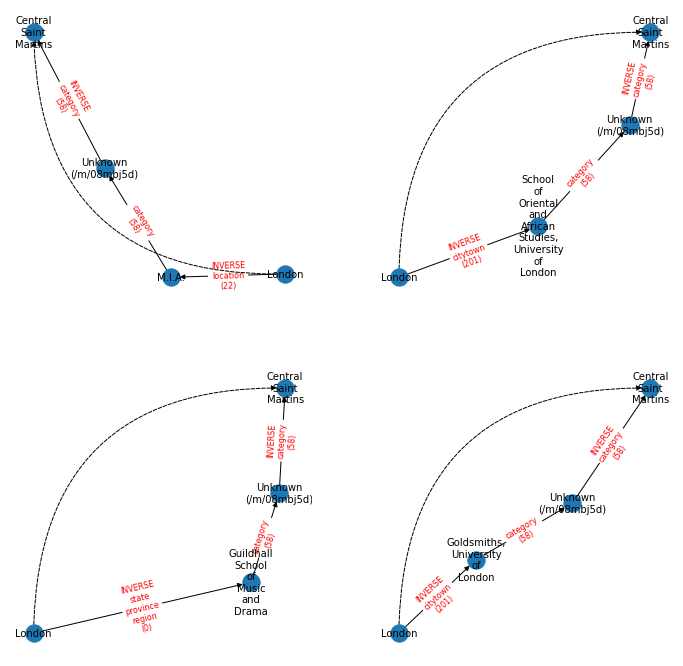

In [50]:
pred.path_importance(model, head_id=4695, tail_id=5180, relation_id=31)

In [51]:
pred.inference(model_inference, "Good Will Hunting", "genre", top_k=5)

Closest match for query ('Good Will Hunting', '/film/film/genre (4)'), (12481, 4)
4


[('drama film 3776 *', 4.605),
 ('romance film 743 *', 3.076),
 ('independent film 11871 *', 2.969),
 ('coming of age 13438 *', 2.725),
 ('adventure film 13511', 2.457)]

Finding paths (('Good Will Hunting', '/film/film/genre (4)', 'historical drama'))
Weight of path 0.0075.
   (Good Will Hunting, /film/film/genre (4), drama film)
   (drama film, /media common/netflix genre/titles (166), The Painted Veil)
   (The Painted Veil, /film/film/genre (4), historical drama)
Weight of path 0.0074.
   (Good Will Hunting, /film/film/genre (4), drama film)
   (drama film, /media common/netflix genre/titles (166), The Last King of Scotland)
   (The Last King of Scotland, /film/film/genre (4), historical drama)
Weight of path 0.0074.
   (Good Will Hunting, /film/film/genre (4), drama film)
   (drama film, /media common/netflix genre/titles (166), The Quiet American)
   (The Quiet American, /film/film/genre (4), historical drama)
Weight of path 0.0074.
   (Good Will Hunting, /film/film/genre (4), drama film)
   (drama film, /media common/netflix genre/titles (166), The Portrait of a Lady)
   (The Portrait of a Lady, /film/film/genre (4), historical drama)


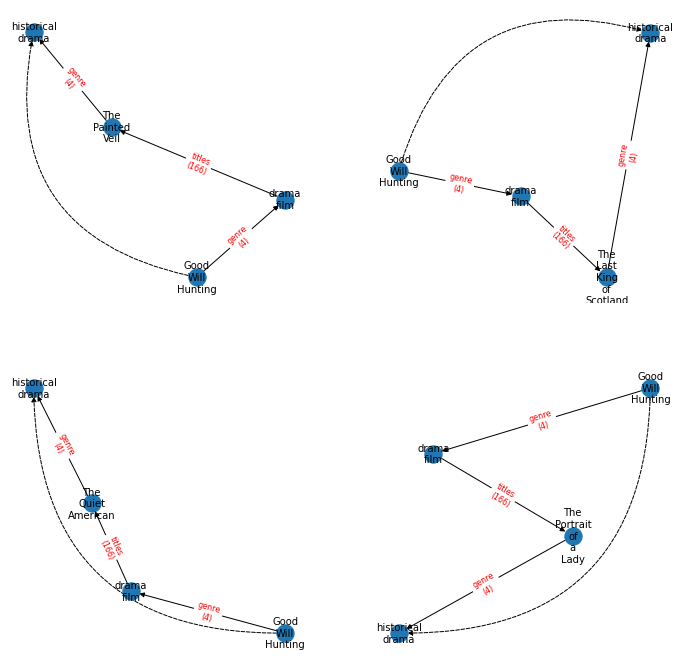

In [52]:
pred.path_importance(model, head_id=12481, tail_id=1810, relation_id=4)

# Conclusion
Using a subgraph of FB15k-237 we have trained an inductive link prediction model for knowledge graphs. This model has been used to infer missing connections in the full FB15k-237 graph and could demonstrate the applied reasoning by outputting the paths in the graph that were most relevant to a given prediction.

As a next step you could try to speed up training by replicating the model four times on a POD-16 or train on a larger graph. this could be achieved by reducing the batch size or pipelining the model over more IPUs. 

Also note that other PyTorch Geometric examples on are available for IPU to solve node-level or graph-level tasks. 